# 점(point) 이상 탐지 실습 - Autoencoder 이용

## 모듈 임포트

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 장치 설정

In [2]:
# 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 데이터 준비

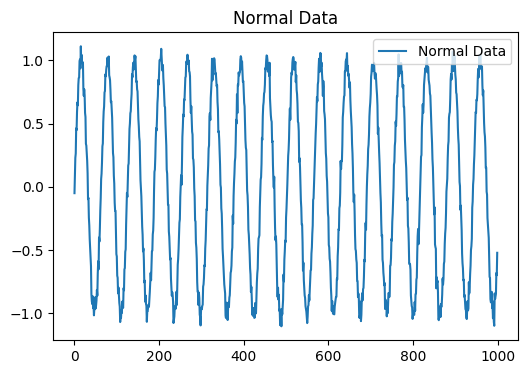

In [3]:
# 정상 데이터 생성
n_points = 1000
time = np.arange(0, n_points)
normal_data = np.sin(0.1 * time) + np.random.normal(0, 0.05, len(time))

# 정상 데이터 시각화
plt.figure(figsize=(6, 4))
plt.plot(normal_data, label='Normal Data')
plt.title("Normal Data")
plt.legend()
plt.show()

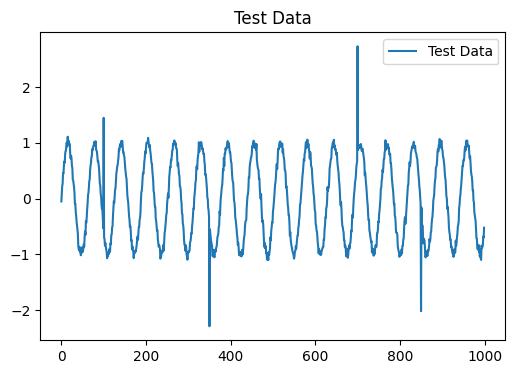

In [4]:
# 테스트 데이터 생성
test_data = normal_data.copy()

# 이상치 데이터는 특정 '지점'에서 비정상적인 값을 보이도록 생성
test_data[100] += 2.0
test_data[350] -= 1.8
test_data[700] += 2.0
test_data[850] -= 1.8

# 테스트 데이터 시각화
plt.figure(figsize=(6, 4))
plt.plot(test_data, label='Test Data')
plt.title("Test Data")
plt.legend()
plt.show()

## 데이터 전처리

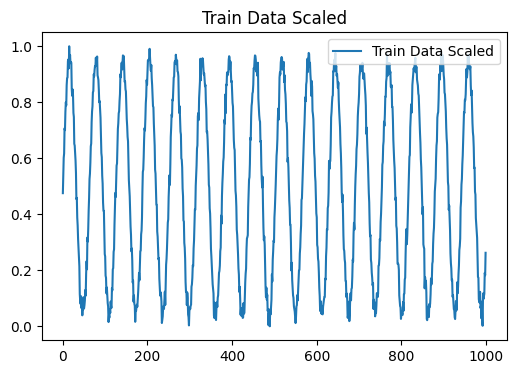

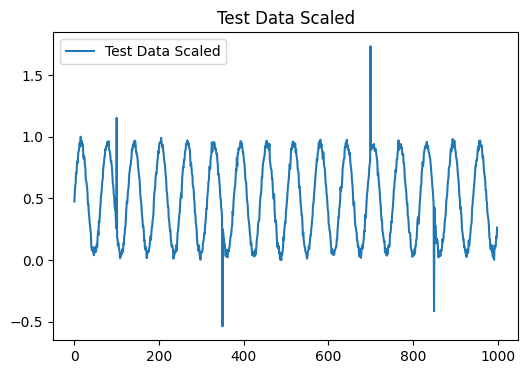

In [5]:
# 데이터 스케일링
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(normal_data.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.reshape(-1, 1))

plt.figure(figsize=(6, 4))
plt.plot(train_data_scaled, label='Train Data Scaled')
plt.title("Train Data Scaled")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(test_data_scaled, label='Test Data Scaled')
plt.title("Test Data Scaled")
plt.legend()
plt.show()

In [6]:
# 데이터를 PyTorch 텐서로 변환하고 디바이스로 이동
train_tensor = torch.FloatTensor(train_data_scaled).to(device)
test_tensor = torch.FloatTensor(test_data_scaled).to(device)

print(f"Train tensor shape: {train_tensor.shape}") # (samples, features)
print(f"Test tensor shape: {test_tensor.shape}")

Train tensor shape: torch.Size([1000, 1])
Test tensor shape: torch.Size([1000, 1])


## 모델 정의

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # 인코더: 입력 데이터를 저차원으로 압축
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4), # 잠재 공간 (Latent Space)
            nn.ReLU()
        )
        # 디코더: 압축된 데이터를 원본 차원으로 복원
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim),
            nn.Sigmoid() # 스케일링된 출력이므로 0~1 사이 값을 위해 Sigmoid 사용
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
# 모델 인스턴스 생성 및 디바이스로 이동
input_dim = train_tensor.shape[1]
model = Autoencoder(input_dim).to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## 모델 학습

In [9]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.L1Loss() # MAE Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

# 학습 루프
model.train() # 모델을 학습 모드로 설정
for epoch in range(num_epochs):
    # 순전파
    outputs = model(train_tensor)
    loss = criterion(outputs, train_tensor) # 입력 자신을 복원하는 것이 목표

    # 역전파 및 가중치 업데이트
    optimizer.zero_grad() # 그래디언트 초기화
    loss.backward()       # 역전파
    optimizer.step()      # 가중치 업데이트

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.292399
Epoch [20/100], Loss: 0.291170
Epoch [30/100], Loss: 0.290051
Epoch [40/100], Loss: 0.289223
Epoch [50/100], Loss: 0.288542
Epoch [60/100], Loss: 0.288013
Epoch [70/100], Loss: 0.287499
Epoch [80/100], Loss: 0.287004
Epoch [90/100], Loss: 0.286537
Epoch [100/100], Loss: 0.286008


## 이상치 탐지

In [10]:
# 모델을 평가 모드로 설정
model.eval()

# 임계값(Threshold) 설정
with torch.no_grad():
    reconstructed_train = model(train_tensor)
    train_error = torch.mean(torch.abs(train_tensor - reconstructed_train), dim=1).cpu().numpy()
    threshold = np.mean(train_error) + 3 * np.std(train_error)

print(f"\n이상치 탐지 임계값(Threshold): {threshold:.4f}")


이상치 탐지 임계값(Threshold): 0.7030


In [11]:
# 테스트 데이터 복원 및 복원 오차 계산
with torch.no_grad(): # 그래디언트 계산 비활성화
    reconstructed = model(test_tensor)
    # 텐서를 CPU로 옮기고 NumPy 배열로 변환
    reconstruction_error = torch.mean(torch.abs(test_tensor - reconstructed), dim=1).cpu().numpy()

# 임계값을 초과하는 데이터 포인트를 이상치로 판별
anomalies_idx = np.where(reconstruction_error > threshold)[0]
print(f"탐지된 이상치 인덱스: {anomalies_idx}")

탐지된 이상치 인덱스: [350 700 850]


## 결과 시각화

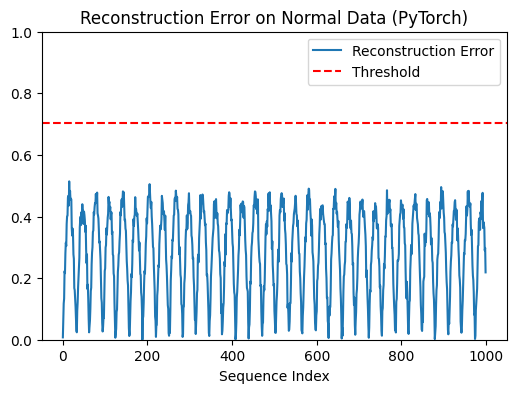

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(train_error, label='Reconstruction Error')
plt.ylim(0.0, 1.0)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Normal Data (PyTorch)")
plt.xlabel("Sequence Index")
plt.legend()
plt.show()

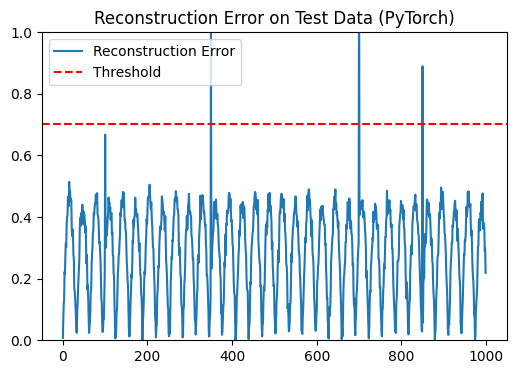

In [13]:
# 복원 오차 시각화
plt.figure(figsize=(6, 4))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.ylim(0.0, 1.0)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Test Data (PyTorch)")
plt.legend()
plt.show()

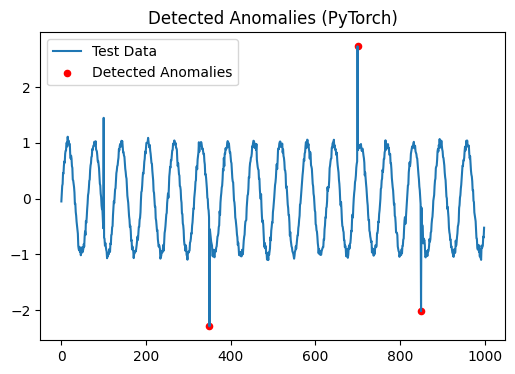

In [14]:
# 테스트 데이터와 탐지된 이상치 함께 시각화
plt.figure(figsize=(6, 4))
plt.plot(test_data, label='Test Data')
plt.scatter(anomalies_idx, test_data[anomalies_idx], color='red', s=20, label='Detected Anomalies')
plt.title("Detected Anomalies (PyTorch)")
plt.legend()
plt.show()